# Learned Prior


Same as the Particle Filter this method uses deep learning networks to update the weights. A location likelihood, computed by the dot product between floorplan features extracted by UNet and motion features extracted by LSTM (the standard LSTM in a many-to-one setting), is used to weight the particles.

#### Refernces

[1] D. Melamed, “Learnable Spatio-Temporal Map Embeddings for Deep Inertial Localization,” p. 51.

[2]	O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation.” arXiv, May 18, 2015. Accessed: Nov. 05, 2022. [Online]. Available: http://arxiv.org/abs/1505.04597

No dataset provided by authors. Used FusionDHL dataset to implement.

[3] Fusion-DHL: WiFi, IMU, and Floorplan Fusion for Dense History of Locations in Indoor Environments, https://github.com/Sachini/Fusion-DHL, GitHub, September 21, 2022



### Architecture of Learned Prior Implementation 

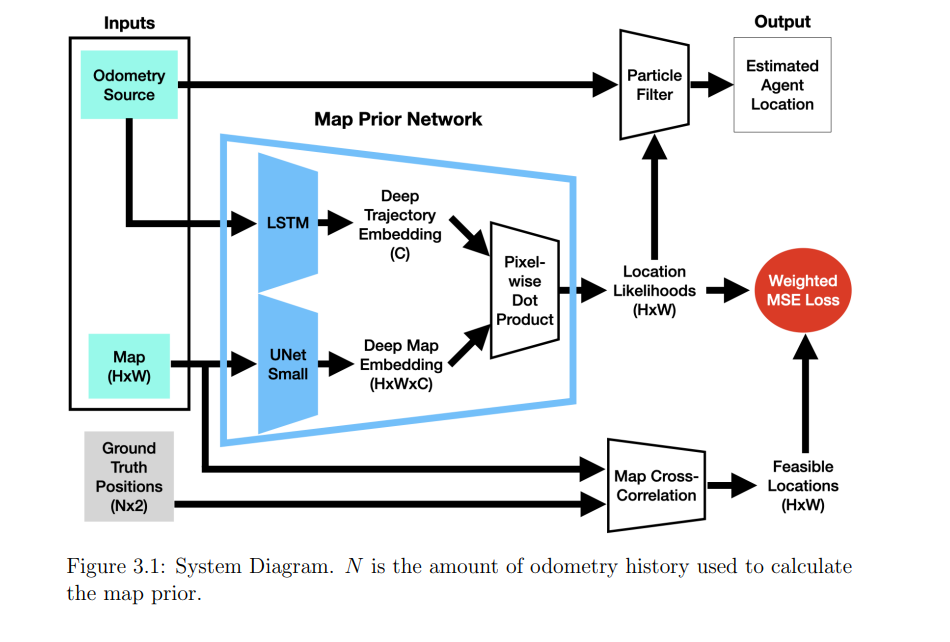

### U-Net Small Implementation

Referenced Paper

O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation.” arXiv, May 18, 2015. Accessed: Nov. 05, 2022. [Online]. Available: http://arxiv.org/abs/1505.04597

In [ ]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 32, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

if __name__ == "__main__":
    # inputs = torch.randn((2, 32, 256, 256))
    # e = encoder_block(32, 64)
    # x, p = e(inputs)
    # print(x.shape, p.shape)
    #
    # d = decoder_block(64, 32)
    # y = d(p, x)
    # print(y.shape)
    
    from torchvision import transforms as tf
    from PIL import Image
    
    image = Image.open("FloorPlan.png").convert('RGB').resize((512,512))
    transforms = tf.Compose([tf.Resize(512), 
                        tf.ToTensor()])

    img_tensor = transforms(image).unsqueeze(0)
    #print(img_tensor.shape)

    #inputs = torch.randn((2, 3, 512, 512))
    model = build_unet()
    y_Unet = model(img_tensor)
    print(y_Unet.shape)

torch.Size([1, 32, 512, 512])


### LSTM Implementation

Referenced Site

Anis, A. (2022) Pytorch LSTM: The Definitive Guide, cnvrg. Available at: https://cnvrg.io/pytorch-lstm/ (Accessed: November 5, 2022). 

In [ ]:
import pandas as pd

import csv #import to use the csv module

i=[]
with open('C:/Users/Sandalu Karunasena/Downloads/send/send/data.csv', mode="r") as csv_file: #"r" represents the read mode
    reader1 = csv.reader(csv_file) #this is the reader object

    for item in reader1:
    # you have to loop through the document to get each data
        i.append(item)
        
j=[]
with open('C:/Users/Sandalu Karunasena/Downloads/send/send/FusionLocations.csv', mode="r") as csv_file: #"r" represents the read mode
    reader1 = csv.reader(csv_file) #this is the reader object
    
    for item in reader1:
    # you have to loop through the document to get each data
        j.append(item)
        

for count in range(1,len(i)):
    a = round(float(i[count][0]),3)
    i[count][0] = a
    
for count in range(1,len(j)):
    b = round(float(j[count][0]),3)
    j[count][0] = b
    
j.pop(0)
i.pop(0)

df1 = pd.DataFrame.from_records(j,columns=["T (s)", "Latitude", "Longitude"])
df2 = pd.DataFrame.from_records(i,columns=["T (s)", "acce_1", "acce_2", "acce_3", "gyro_1", "gyro_2", "gyro_3"])

import pandas as pd

# using merge function by setting how='inner'
output = pd.merge(df1, df2,
				on='T (s)',
				how='inner')

output.to_csv('CSV3.csv')

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms



import h5py
import numpy as np
import pandas as pd


df = pd.read_csv("CSV3.csv", index_col = "T (s)", parse_dates=True)

X = df.iloc[:, 3:9]
y = df.iloc[:, 1:3]


In [ ]:
# Calculate X direction,
# X direction -- Longitude
# X's Plus direction = Longitude's Plus Direction

# Calculate Y direction,
# Y direction -- Latitude
# Y's Plus direction = Latitude's Negative Direction
from math import cos, asin, sqrt, pi, atan2

X_0_in_longitude= -123.003721
Y_0_in_latitude= 49.228363
pixelspermeter=2.5

# Distance between Two Lat,Lon

print(y)

def distanceLatLonInMeters(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742000 * asin(sqrt(a))

x_dir_pixels=[]
y_dir_pixels=[]
x_dir_meters=[]
y_dir_meters=[]

for tuple in y.itertuples():
    meters_in_x_direction=abs(distanceLatLonInMeters(Y_0_in_latitude,X_0_in_longitude,Y_0_in_latitude,tuple[2]))
    meters_in_y_direction=abs(distanceLatLonInMeters(Y_0_in_latitude,X_0_in_longitude,tuple[1],X_0_in_longitude))
    
    pixels_in_x_direction=round((meters_in_x_direction*2.5*512)/1612)
    pixels_in_y_direction=round((meters_in_y_direction*2.5*512)/1141)
    
    x_dir_pixels.append(pixels_in_x_direction)
    y_dir_pixels.append(pixels_in_y_direction)
    
    x_dir_meters.append(meters_in_x_direction)
    y_dir_meters.append(meters_in_y_direction)
    
    ##print(pixels_in_x_direction,pixels_in_y_direction,meters_in_x_direction,meters_in_y_direction)
    
updated_df=y.copy()
updated_df["Pixels In X Direction"] = x_dir_pixels
updated_df["Pixels In Y Direction"] = y_dir_pixels
updated_df["Meters In X Direction"] = x_dir_meters
updated_df["Meters In Y Direction"] = y_dir_meters

           Latitude   Longitude
T (s)                          
6520.509  49.226697 -123.001859
6523.504  49.226632 -123.001839
6534.509  49.226649 -123.001877
6544.504  49.226612 -123.001855
6560.499  49.226551 -123.001657
...             ...         ...
9106.329  49.226923 -123.000895
9108.144  49.226913 -123.000877
9109.324  49.226907 -123.000869
9110.504  49.226900 -123.000861
9132.509  49.226740 -123.001225

[247 rows x 2 columns]


In [ ]:
updated_df

,Latitude,Longitude,Pixels In X Direction,Pixels In Y Direction,Meters In X Direction,Meters In Y Direction
T (s),,,,,,
6520.509,49.226697,-123.001859,107,208,135.209840,185.250757
6523.504,49.226632,-123.001839,109,216,136.662148,192.478408
6534.509,49.226649,-123.001877,106,214,133.902764,190.588114
6544.504,49.226612,-123.001855,108,218,135.500296,194.702321
6560.499,49.226551,-123.001657,119,226,149.878145,201.485202
...,...,...,...,...,...,...
9106.329,49.226923,-123.000895,163,180,205.211064,160.120700
9108.144,49.226913,-123.000877,164,181,206.518136,161.232644
9109.324,49.226907,-123.000869,164,182,207.099063,161.899814


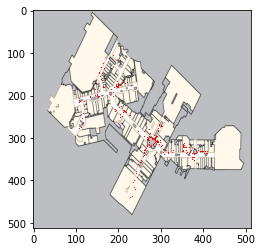

In [ ]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

image = Image.open('FloorPlan.png')
rsize = image.resize((512,512))
#floorplan0 = image.imread('FloorPlan.png')
floorplan0 = np.asarray(rsize)
plt.imshow(floorplan0)
for row in updated_df.itertuples():
    plt.plot(row[3],row[4] , marker=',', color="red")
plt.savefig('visited_areas.png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

y = updated_df.iloc[:, 2:4]

y_mm =y.to_numpy()
X_ss = ss.fit_transform(X)
#y_mm = mm.fit_transform(y) 

#first 200 for training

X_train = X_ss[:210, :]
X_test = X_ss[200:, :]

y_train = y_mm[:210, :]
y_test = y_mm[200:, :] 

X_train_temp=[]

for j in range(200):
    acc1 = []
    acc2 = []
    acc3 = []
    gyro1 = []
    gyro2 = []
    gyro3 = []

    for i in range(10):
        acc1.append(X_train[i+j][0])
        acc2.append(X_train[i+j][1])
        acc3.append(X_train[i+j][2])
        gyro1.append(X_train[i+j][3])
        gyro2.append(X_train[i+j][4])
        gyro3.append(X_train[i+j][5])

    arr = np.concatenate((acc1,acc2,acc3,gyro1,gyro2,gyro3))

    X_train_temp.append(arr)
    
X_train = np.array(X_train_temp)

y_train_temp=[]

for j in range(200):
    lat = []
    lon = []
    for i in range(10):
        lat.append(y_train[i+j][0])
        lon.append(y_train[i+j][1])

    arr = np.concatenate((lat,lon))

    y_train_temp.append(arr)
    
y_train = np.array(y_train_temp)
print(y_train)

X_test_temp=[]

for j in range(37):
    acc1 = []
    acc2 = []
    acc3 = []
    gyro1 = []
    gyro2 = []
    gyro3 = []

    for i in range(10):
        acc1.append(X_test[i+j][0])
        acc2.append(X_test[i+j][1])
        acc3.append(X_test[i+j][2])
        gyro1.append(X_test[i+j][3])
        gyro2.append(X_test[i+j][4])
        gyro3.append(X_test[i+j][5])

    arr = np.concatenate((acc1,acc2,acc3,gyro1,gyro2,gyro3))

    X_test_temp.append(arr)
    
X_test = np.array(X_test_temp)

y_test_temp=[]

for j in range(37):
    lat = []
    lon = []
    for i in range(10):
        lat.append(y_test[i+j][0])
        lon.append(y_test[i+j][1])

    arr = np.concatenate((lat,lon))

    y_test_temp.append(arr)
    
y_test = np.array(y_test_temp)

print("Training Shape",X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 


[[107 109 106 ... 267 267 255]
 [109 106 108 ... 267 255 243]
 [106 108 119 ... 255 243 216]
 ...
 [288 288 287 ... 300 298 286]
 [288 287 283 ... 298 286 249]
 [287 283 282 ... 286 249 241]]
Training Shape (200, 60) (200, 20)
Testing Shape (37, 60) (37, 20)


In [ ]:
y_sample = y_train[0]
expectedOut = torch.zeros(512,512)

for i in range(10):
    y_loc = y_sample[2*i:2*i+2]
    expectedOut[y_loc[1]][y_loc[0]]=1
print(expectedOut[109][107])

tensor(1.)


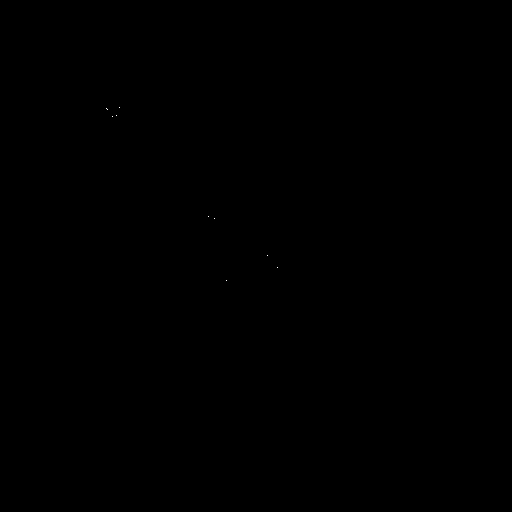

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

tensor_to_image(expectedOut)

In [ ]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 60]) torch.Size([200, 20])
Testing Shape torch.Size([37, 1, 60]) torch.Size([37, 20])


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    
    
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 60 #number of features
hidden_size = 32 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
outputs = lstm1.forward(X_train_tensors_final) #forward pass

In [ ]:
#UNet_repeat=y_Unet.repeat(200,1,1,1)
print("UNet Output",y_Unet.shape, "LSTM Output",outputs.shape)

UNet Output torch.Size([1, 32, 512, 512]) LSTM Output torch.Size([200, 1])


In [ ]:
def mul(y_Unet,outputs):
    y_Unet2=y_Unet.expand(200,32,512,512)
    output2=outputs.unsqueeze_(-1)
    output3=output2.expand(200,32,512)
    output4=output3.unsqueeze_(-1)
    output5=output4.expand(200,32,512,512)
    print(y_Unet2.shape,output5.shape)
    mul = y_Unet2*output5
    return mul.sum(1)

# location_Likelihood = mul(y_Unet,outputs)
# location_Likelihood.shape

In [ ]:
# print(location_Likelihood[20])
# sigmoid_location = torch.sigmoid(location_Likelihood[0])*255

In [ ]:
# import numpy as np 
# import matplotlib.pyplot as plt
# from PIL import Image

# H = sigmoid_location.detach().numpy()
# image = Image.fromarray(H).convert('L')
# plt.imshow(image, cmap = 'gray')
# plt.show()

In [ ]:
# num_epochs = 199 #1000 epochs
# learning_rate = 0.001 #0.001 lr

# criterion = torch.nn.MSELoss()    # mean-squared error for regression
# #optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

# for epoch in range(num_epochs):
#     #outputs = lstm1.forward(X_train_tensors_final) #forward pass
#     #optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
#     # obtain the loss function
#     loss = criterion(location_Likelihood[epoch], expectedOut)
    
#     #loss.backward() #calculates the loss of the loss function
 
#     #optimizer.step() #improve from loss, i.e backprop
#     if epoch % 10 == 0:
#         print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
# #       print(X_train_tensors_final.shape)
# #       print(outputs.shape)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batchSize = 10
dataset = TensorDataset(X_train_tensors_final, y_train_tensors)
train_loader = DataLoader(dataset, batchSize, shuffle=True, drop_last=True)
dataset = TensorDataset(X_test_tensors_final, y_test_tensors)
val_loader = DataLoader(dataset, batchSize, drop_last=True)

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, X_train_tensors_final_shape):
        super().__init__()
        self.lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final_shape) #our lstm class 
        self.unet = build_unet()
        
    def forward(self,img_tensor, X_train_tensors_final, batchSize):
        lstm_output = self.lstm1.forward(X_train_tensors_final) #forward pass
        Unet_output = self.unet(img_tensor)
        location_Likelihood = self.mul(Unet_output, lstm_output, batchSize)
        sigmoid_location = torch.sigmoid(location_Likelihood)
        return sigmoid_location
    
    def mul(self,y_Unet,outputs, batchSize):
        y_Unet2=y_Unet.expand(batchSize,32,512,512)
        output2=outputs.unsqueeze_(-1)
        output3=output2.expand(batchSize,32,512)
        output4=output3.unsqueeze_(-1)
        output5=output4.expand(batchSize,32,512,512)
        mul = y_Unet2*output5
        
        return mul.sum(1)

  
    
    def training_step(self, img_tensor, batch, batchSize):
        xb, yb = batch 
        out = self(img_tensor, xb, batchSize)                  # Generate predictions
        expectedOuts = []
        for i in range(len(yb)):
            expectedOut = torch.zeros(512,512)
            y_sample = yb[i]
            for j in range(10):
                y_loc = y_sample[2*j:2*j+2]
                expectedOut[int(y_loc[1].item())][int(y_loc[0].item())]=1
            expectedOuts.append(expectedOut)
        labels = torch.stack(expectedOuts)
        criterion = torch.nn.MSELoss() 
        loss = criterion(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, img_tensor, batch, batchSize):
        xb, yb = batch 
        out = self(img_tensor, xb, batchSize)                  # Generate predictions
        expectedOuts = []
        for i in range(len(yb)):
            expectedOut = torch.zeros(512,512)
            y_sample = yb[i]
            for j in range(10):
                y_loc = y_sample[2*j:2*j+2]
                expectedOut[int(y_loc[1].item())][int(y_loc[0].item())]=1
            expectedOuts.append(expectedOut)
        labels = torch.stack(expectedOuts)
        criterion = torch.nn.MSELoss() 
        loss = criterion(out, labels)         # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    


In [ ]:
input_size = 60 #number of features
hidden_size = 32 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

model = MyModel(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])
#output = model.forward(img_tensor, X_train_tensors_final)

In [ ]:
def evaluate(model, val_loader, img_tensor,batchSize):
    outputs = [model.validation_step(img_tensor, batch, batchSize) for batch in val_loader]
    return model.validation_epoch_end(outputs)

    
def accuracy(outputs, labels):
    fOutputs = torch.flatten(outputs)
    roundedOutputs = (fOutputs>0.5).float() 
    fLabels  = torch.flatten(labels)
    roundedLabels = (fLabels>0.5).float() 
    #_, preds = torch.max(outputs, dim=1)
    return torch.Tensor.float(torch.sum(roundedOutputs == roundedLabels)/len(roundedOutputs))

In [ ]:
def fit(epochs, lr, model, train_loader, img_tensor, batchSize,val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(img_tensor,batch, batchSize)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader, img_tensor,batchSize)
        model.epoch_end(epoch, result)
        history.append(result)
      
    return history

In [ ]:
fit(2, 0.01, model, train_loader, img_tensor, batchSize, val_loader)

Epoch [0], val_loss: 0.2504, val_acc: 0.5429
Epoch [1], val_loss: 0.2481, val_acc: 0.3943


[{'val_loss': 0.2503701150417328, 'val_acc': 0.5428594946861267},
 {'val_loss': 0.24813096225261688, 'val_acc': 0.39428457617759705}]

In [ ]:
output = model.forward(img_tensor, X_train_tensors_final[0:2],2)
print(output)

tensor([[[0.4956, 0.4913, 0.4964,  ..., 0.4955, 0.4896, 0.4928],
         [0.5012, 0.4962, 0.5025,  ..., 0.5048, 0.4974, 0.5037],
         [0.4938, 0.4923, 0.4997,  ..., 0.5039, 0.4902, 0.4961],
         ...,
         [0.4916, 0.4961, 0.5007,  ..., 0.5038, 0.4868, 0.4946],
         [0.4938, 0.4927, 0.4994,  ..., 0.4995, 0.4933, 0.4936],
         [0.4993, 0.5024, 0.5042,  ..., 0.5040, 0.5016, 0.5005]],

        [[0.4879, 0.4759, 0.4901,  ..., 0.4876, 0.4715, 0.4801],
         [0.5032, 0.4894, 0.5069,  ..., 0.5134, 0.4927, 0.5101],
         [0.4831, 0.4788, 0.4991,  ..., 0.5109, 0.4730, 0.4891],
         ...,
         [0.4769, 0.4892, 0.5019,  ..., 0.5104, 0.4636, 0.4852],
         [0.4829, 0.4798, 0.4982,  ..., 0.4985, 0.4816, 0.4823],
         [0.4979, 0.5065, 0.5116,  ..., 0.5110, 0.5043, 0.5015]]],
       grad_fn=<SigmoidBackward0>)


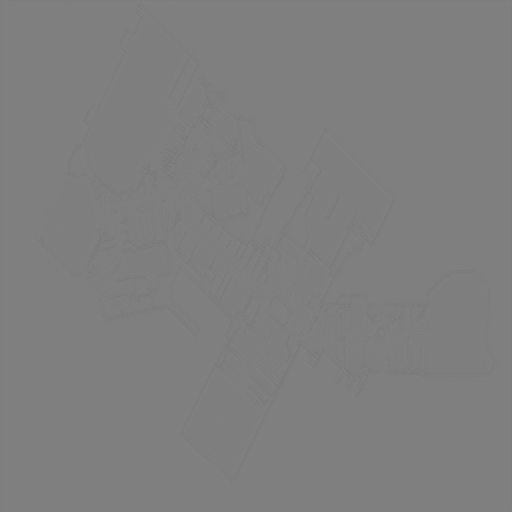

In [ ]:
tensor_to_image(output[0].detach().numpy())